In [1]:
!nvidia-smi

Sun Apr  6 08:00:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:31:00.0 Off |                    0 |
| N/A   31C    P8             16W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/ubuntu/projects/sure-football-analysis


In [3]:
from roboflow import Roboflow
# from google.colab import userdata
from IPython.display import Image
from dotenv import load_dotenv

env_path = f"{HOME}/.env"
load_dotenv(dotenv_path=env_path)
ROBOFLOW_API_KEY = os.environ.get("ROBOFLOW_API_KEY")

# from inference import get_model
from ultralytics import YOLO

# ROBOFLOW_API_KEY = os.environ.get("ROBOFLOW_API_KEY")
# PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/12"
# PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)
PLAYER_DETECTION_MODEL = YOLO("app/models/yolo11_football_v2/weights/best.pt")
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [ ]:
from tqdm import tqdm
import supervision as sv

PLAYER_ID = 2
STRIDE = 30
SOURCE_VIDEO_PATH = "app/test_data/raw/121364_0.mp4"

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    # result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    # detections = sv.Detections.from_inference(result)
    detections = sv.Detections.from_ultralytics(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [5]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 16it [00:03,  5.12it/s]


In [10]:
import joblib

MODEL_SAVE_DIR = "app/models/team_classifiers"  # Change this to your desired directory

# Load YOLO model
# PLAYER_DETECTION_MODEL = YOLO(f"{MODEL_SAVE_DIR}/yolo_model.pt")

# Load SigLIP model
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(f"{MODEL_SAVE_DIR}/siglip_model").to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(f"{MODEL_SAVE_DIR}/siglip_model")

# Load UMAP reducer
REDUCER = joblib.load(f"{MODEL_SAVE_DIR}/umap_reducer.joblib")

# Load KMeans model
CLUSTERING_MODEL = joblib.load(f"{MODEL_SAVE_DIR}/kmeans_model.joblib")

# Load TeamClassifier
team_classifier = joblib.load(f"{MODEL_SAVE_DIR}/team_classifier.joblib")

print("All models loaded successfully!")

All models loaded successfully!


In [ ]:
import umap
from sklearn.cluster import KMeans
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

# REDUCER = umap.UMAP(n_components=3)
# CLUSTERING_MODEL = KMeans(n_clusters=2)
# team_classifier = TeamClassifier(device="cuda")

projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    # result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    # detections = sv.Detections.from_inference(result)
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier.fit(crops)

In [12]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)


0: 1280x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 66.0ms
Speed: 6.3ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


Embedding extraction: 1it [00:00,  8.72it/s]


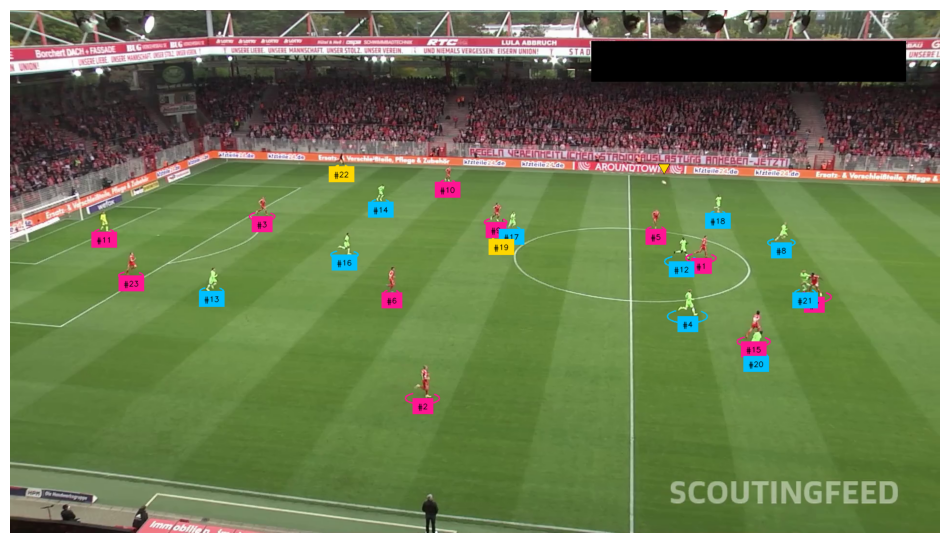

In [13]:
import supervision as sv

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
# detections = sv.Detections.from_inference(result)
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [ ]:
import supervision as sv
from tqdm import tqdm
import numpy as np
import cv2
import os
from collections import defaultdict

# ----- Class IDs -----
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# ----- Configuration -----
IOU_THRESHOLD = 0.05
MIN_INTERACTION_FRAMES = 5  # ~0.33 seconds at 30 FPS
CLIP_PADDING_SECONDS = 2
ACTIONS_DIR = "app/test_data/predicted/actions"
os.makedirs(ACTIONS_DIR, exist_ok=True)

In [36]:
# ----- Interaction Tracking Class -----
class InteractionTracker:
    def __init__(self, fps):
        self.fps = fps
        self.active_interactions = defaultdict(lambda: {
            'start_frame': None,
            'end_frame': None,
            'ball_id': None,
            'player_id': None,
            'active': False
        })
        self.confirmed_interactions = []
        self.frame_buffer = []

    def update(self, frame_number, current_frame, interactions):
        # Store frame in rolling buffer
        self.frame_buffer.append((frame_number, current_frame))
        max_buffer_size = int((CLIP_PADDING_SECONDS * 2) * self.fps) + 10
        if len(self.frame_buffer) > max_buffer_size:
            self.frame_buffer.pop(0)

        # Update active interactions
        current_keys = set()
        for ball_id, player_id in interactions:
            key = (ball_id, player_id)
            current_keys.add(key)
            if not self.active_interactions[key]['active']:
                self.active_interactions[key] = {
                    'start_frame': frame_number,
                    'end_frame': frame_number,
                    'ball_id': ball_id,
                    'player_id': player_id,
                    'active': True
                }
            else:
                self.active_interactions[key]['end_frame'] = frame_number

        # Check for ended interactions
        ended_keys = [k for k in self.active_interactions 
                     if k not in current_keys and self.active_interactions[k]['active']]
        for key in ended_keys:
            duration = (self.active_interactions[key]['end_frame'] - 
                       self.active_interactions[key]['start_frame'])
            if duration >= MIN_INTERACTION_FRAMES:
                self.confirmed_interactions.append(self.active_interactions[key])
            self.active_interactions[key]['active'] = False

    def get_clip_frames(self, interaction):
        padding_frames = int(CLIP_PADDING_SECONDS * self.fps)
        start_frame = max(0, interaction['start_frame'] - padding_frames)
        end_frame = interaction['end_frame'] + padding_frames
        
        return [frame for (f_num, frame) in self.frame_buffer 
                if start_frame <= f_num <= end_frame]


In [37]:
# ----- Detection and Tracking Setup -----
tracker = sv.ByteTrack()
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

def process_frame(frame, frame_number, tracker, interaction_tracker):
    # Run detection
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)

    # Process ball separately
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(ball_detections.xyxy, px=10)

    # Process other detections
    other_detections = detections[detections.class_id != BALL_ID]
    other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)

    # Merge ALL detections for tracking (including ball)
    all_detections = sv.Detections.merge([ball_detections, other_detections])
    tracked_detections = tracker.update_with_detections(all_detections)

    # Separate tracked entities
    ball_mask = tracked_detections.class_id == BALL_ID
    player_mask = np.isin(tracked_detections.class_id, [PLAYER_ID, GOALKEEPER_ID])
    
    balls = tracked_detections[ball_mask]
    players = tracked_detections[player_mask]

    # Detect interactions
    current_interactions = []
    if len(balls) > 0 and len(players) > 0:
        iou_matrix = sv.box_iou_batch(balls.xyxy, players.xyxy)  # Fixed IoU calculation
        interacting_pairs = np.argwhere(iou_matrix > IOU_THRESHOLD)
        
        for ball_idx, player_idx in interacting_pairs:
            if ball_idx < len(balls.tracker_id) and player_idx < len(players.tracker_id):
                current_interactions.append(
                    (balls.tracker_id[ball_idx], players.tracker_id[player_idx])
                )

    # Update interaction tracker
    interaction_tracker.update(frame_number, frame, current_interactions)

    # Annotate frame
    labels = [f"#{tid}" for tid in tracked_detections.tracker_id]
    annotated_frame = ellipse_annotator.annotate(frame.copy(), tracked_detections)
    annotated_frame = label_annotator.annotate(annotated_frame, tracked_detections, labels)
    annotated_frame = triangle_annotator.annotate(annotated_frame, balls)
    
    return annotated_frame


In [31]:
# ----- Clip Saving Function -----
def save_interaction_clips(interaction_tracker):
    for idx, interaction in enumerate(interaction_tracker.confirmed_interactions):
        clip_frames = interaction_tracker.get_clip_frames(interaction)
        if not clip_frames:
            continue

        clip_path = os.path.join(ACTIONS_DIR, 
                               f"action_{idx}_b{interaction['ball_id']}_p{interaction['player_id']}.mp4")
        
        # Get video properties from first frame
        height, width = clip_frames[0].shape[:2]
        
        writer = cv2.VideoWriter(clip_path, cv2.VideoWriter_fourcc(*'mp4v'), 
                               interaction_tracker.fps, (width, height))
        for frame in clip_frames:
            writer.write(frame)
        writer.release()


In [ ]:
# ----- Main Execution -----
SOURCE_VIDEO_PATH = "app/test_data/raw/08fd33_0.mp4"
OUTPUT_VIDEO_PATH = "08fd33_0-result2.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
interaction_tracker = InteractionTracker(fps=video_info.fps)

with sv.VideoSink(OUTPUT_VIDEO_PATH, video_info) as sink:
    for frame_number, frame in enumerate(tqdm(sv.get_video_frames_generator(SOURCE_VIDEO_PATH), 
                                           desc="Processing video")):
        annotated_frame = process_frame(frame, frame_number, tracker, interaction_tracker)
        sink.write_frame(annotated_frame)

# Save confirmed interactions
print(f"Found {len(interaction_tracker.confirmed_interactions)} interactions")
for idx, interaction in enumerate(interaction_tracker.confirmed_interactions):
    clip_frames = interaction_tracker.get_clip_frames(interaction)
    if not clip_frames:
        continue

    clip_path = os.path.join(ACTIONS_DIR, 
                           f"action_{idx}_b{interaction['ball_id']}_p{interaction['player_id']}.mp4")
    
    height, width = clip_frames[0].shape[:2]
    writer = cv2.VideoWriter(clip_path, cv2.VideoWriter_fourcc(*'mp4v'), 
                           video_info.fps, (width, height))
    for frame in clip_frames:
        writer.write(frame)
    writer.release()

print(f"Saved {len(interaction_tracker.confirmed_interactions)} action clips")

In [40]:
# Save interaction clips
save_interaction_clips(interaction_tracker)
print(f"Saved {len(interaction_tracker.confirmed_interactions)} action clips")

Saved 1 action clips


In [ ]:
import os
import supervision as sv
from tqdm import tqdm
import numpy as np
import cv2
from collections import deque

# ----- Configuration and Annotators -----
SOURCE_VIDEO_PATH = "app/test_data/raw/sr2.mp4"
OUTPUT_VIDEO_PATH = "capitano_masr.mp4"
MINI_CLIP_DIR = "app/test_data/predicted/actions"

# Ensure the mini clip directory exists.
os.makedirs(MINI_CLIP_DIR, exist_ok=True)

# Class IDs (as used in your training)
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)
# (Assuming that sv.ByteTrack is available and provides an update_with_detections() method.)
tracker = sv.ByteTrack()
tracker.reset()

# ----- INITIAL DETECTION AND CLASS ASSIGNMENT ON FIRST FRAME -----
# Create a generator for frames (stride=1 for the first frame)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=1)
first_frame = next(frame_generator)
height, width = first_frame.shape[:2]
fps = 30  # Set this to the desired frames per second

# Initialize the OpenCV video writer for saving the annotated full video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

# ----- HELPER FUNCTIONS -----
def boxes_intersect(box1, box2):
    """Check if two boxes in [x1, y1, x2, y2] format intersect."""
    x1, y1, x2, y2 = box1
    a1, b1, a2, b2 = box2
    return not (x2 < a1 or a2 < x1 or y2 < b1 or b2 < y1)

def check_interaction(players_boxes, ball_boxes):
    """Return True if any player's box intersects with any ball box."""
    for pbox in players_boxes:
        for bbox in ball_boxes:
            if boxes_intersect(pbox, bbox):
                return True
    return False

def process_frame(frame):
    """
    Process the frame with detection, classification, and annotation.
    Returns the annotated frame and a flag indicating if an interaction is detected.
    """
    # Run the detection model on the frame using your pretrained weights.
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)

    # Separate ball detections and pad their boxes.
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # For all other detections, apply non-maximum suppression.
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

    # Process player detections with your team classifier.
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    # Process goalkeeper detections using the helper function.
    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    if len(goalkeepers_detections) > 0:
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

    # Adjust referee detections.
    referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
    referees_detections.class_id -= 1

    # Merge the detections (players, goalkeepers, referees) for tracker initialization.
    initial_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections, referees_detections
    ])

    # ----- INITIALIZE THE TRACKER -----
    initial_detections = tracker.update_with_detections(detections=initial_detections)

    # Annotate the frame.
    labels = [f"#{tid}" for tid in initial_detections.tracker_id]
    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=initial_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=initial_detections, labels=labels)
    annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

    # Check for an interaction between any player and the ball.
    interaction_flag = check_interaction(players_detections.xyxy, ball_detections.xyxy)
    return annotated_frame, interaction_flag

# ----- MINI CLIP RECORDING SETUP -----
# A deque to store the previous 2 seconds (2*fps frames) of annotated frames.
frame_buffer = deque(maxlen=2 * fps)

# Variables to manage mini clip recording
recording = False
recorded_frames = []  # List to accumulate annotated frames for the current clip
recording_frame_count = 0  # Count of frames recorded after interaction trigger
clip_index = 1  # For naming mini clip files

# ----- PROCESS THE VIDEO -----
total_frames = fps * 20  # Process 20 seconds of video (adjust as needed)

# Process the first frame, write it and add its annotated version to the buffer.
annotated_first_frame, interaction = process_frame(first_frame)
video_writer.write(annotated_first_frame)
frame_buffer.append(annotated_first_frame)

with tqdm(total=total_frames - 1, desc="Processing frames") as pbar:
    for frame_num in range(1, total_frames):
        try:
            frame = next(frame_generator)
        except StopIteration:
            break  # End of video

        # Process frame (obtain annotated frame and interaction flag)
        annotated_frame, interaction = process_frame(frame)
        video_writer.write(annotated_frame)
        # Append the annotated frame to our rolling buffer.
        frame_buffer.append(annotated_frame)
        
        # If we detect an interaction and we're not already recording, start a new mini clip.
        if interaction and not recording:
            # Only start if we have enough pre-interaction history.
            if len(frame_buffer) == frame_buffer.maxlen:
                # Initialize the mini clip with the buffered annotated frames.
                recorded_frames = list(frame_buffer)
                # Also add the current annotated frame (which triggered the interaction).
                recorded_frames.append(annotated_frame)
                recording = True
                recording_frame_count = 1  # Already added current frame

        # If currently recording, continue appending annotated frames.
        if recording:
            # Avoid adding the current frame twice if it was already added at the start of recording.
            if recording_frame_count > 1:
                recorded_frames.append(annotated_frame)
            recording_frame_count += 1

            # Once we have recorded 2 seconds of annotated frames after the interaction, we have a 4-second clip.
            if recording_frame_count >= 2 * fps:
                clip_name = os.path.join(MINI_CLIP_DIR, f"clip_{clip_index:03d}.mp4")
                clip_writer = cv2.VideoWriter(clip_name, fourcc, fps, (width, height))
                for clip_frame in recorded_frames:
                    clip_writer.write(clip_frame)
                clip_writer.release()
                print(f"Saved mini clip: {clip_name}")
                clip_index += 1
                recording = False
                recording_frame_count = 0
                recorded_frames = []

        pbar.update(1)

# Finalize the annotated video file.
video_writer.release()


In [53]:
# !pip install qwen-vl-utils[decord]
# !pip install 'accelerate>=0.26.0'

In [52]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import glob

# Load Qwen2.5-VL model and processor
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

# Loop through each saved mini clip and generate a description
clip_files = sorted(glob.glob(os.path.join(MINI_CLIP_DIR, "clip_*.mp4")))

ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install 'accelerate>=0.26.0'`